In [2]:
import numpy as np
import matplotlib.pyplot as plt

A simple inverse problem is

$$Ku(x) = \int_0^x u(y) \mathrm{d}y = \int_0^1 H(x-y)\mathrm{d}y,$$

where $H$ is the Heaviside step function. We can easily verify that the solution to $f(x) = Ku(x)$ is given by $u(x) = f'(x)$.

Upon discretisation with stepsize $h = 1/n$, the inverse problem can be cast as a system of $n$ equations in $n$ unknowns

$$Ku = f.$$

You can use the code provided below to generate the matrix and noisy data for a given $u(x)$.

1. Compute the SVD of $K$ (using `np.linalg.svd`) and plot the singular values and vectors. What do they look like?

2. Plot the coefficients $\langle u_i, f\rangle$ and the singular values $\sigma_i$ to check the discrete Picard condition. What do you notice ?

3. Solve the inverse problem for noisy data using the (regularised) pseudo-inverse; compute the optimal $\alpha$ by computing the bias and variance components of the error. How does the optimal $\alpha$ depend on the noise level? Is this a practically feasible way to compute the optimal $\alpha$?

4. Compare the solutions for $\alpha < \alpha_{opt}$ and $\alpha > \alpha_{opt}$ to the ground truth. What do you notice?

In [3]:
def getK(n):
    h = 1/n;
    x = np.linspace(h/2,1-h/2,n)
    xx,yy = np.meshgrid(x,x)
    K = np.heaviside(xx-yy,1)
    
    return K,x

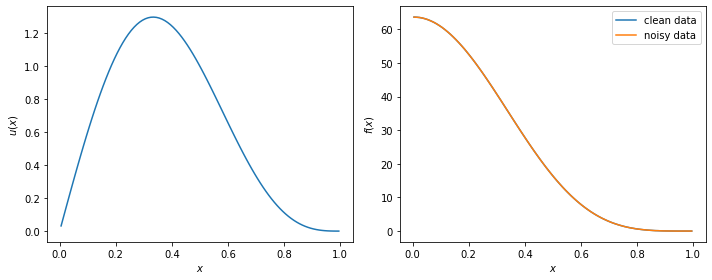

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# define forward operator
n = 100
delta = 1e-2
K,x = getK(n)

# define ground truth and compute data
u = np.sin(np.pi*x) + 0.5*np.sin(2*np.pi*x)
f = K@u

# add noise
noise = np.random.randn(n)
f_delta = f + delta*noise

# plot ground truth and data
fig, axs = plt.subplots(1,2)

axs[0].plot(x,u)
axs[0].set_xlabel(r'$x$')
axs[0].set_ylabel(r'$u(x)$')

axs[1].plot(x,f,label='clean data')
axs[1].plot(x,f_delta,label='noisy data')

axs[1].set_xlabel(r'$x$')
axs[1].set_ylabel(r'$f(x)$')
axs[1].legend()

fig.set_figwidth(10)
fig.tight_layout()
plt.show()

In [38]:
# SVD
U, s, Vh = np.linalg.svd(K, full_matrices=True)

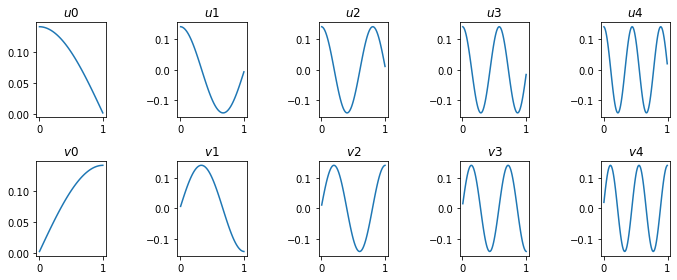

In [39]:
fig, ax = plt.subplots(2,5)

for i in range(5):
  ax[0,i].plot(x,U[:,i])
  ax[0,i].set_title(r'$u$'+str(i))
  ax[1,i].plot(x,Vh[i,:])
  ax[1,i].set_title(r'$v$'+str(i))
  
fig.tight_layout()
fig.set_figwidth(10)

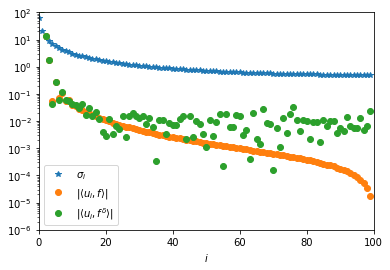

In [40]:
# plot coefficients
fig, ax = plt.subplots(1,1)

ax.semilogy(s,'*',label=r'$\sigma_i$')
ax.semilogy(np.abs(U.T@f),'o',label=r'$|\langle u_i, f\rangle|$')
ax.semilogy(np.abs(U.T@f_delta),'o',label=r'$|\langle u_i, f^{\delta}\rangle|$')
ax.set_xlabel(r'$i$')
ax.set_ylim([1e-6,1e2])
ax.set_xlim([0,n])
ax.legend()

In [41]:
# apply reguarlised pseudo inverse
u_clean = lambda alpha : Vh.T@np.diag(s/(s**2 + alpha))@U.T@f
u_noise = lambda alpha : Vh.T@np.diag(s/(s**2 + alpha))@U.T@f_delta
bias = lambda alpha : np.linalg.norm(u_clean(0) - u_clean(alpha))
variance = lambda alpha : np.linalg.norm(u_clean(alpha) - u_noise(alpha))
total = lambda alpha : np.linalg.norm(u_clean(0) - u_noise(alpha))

optimal alpha =  2.138775510204082


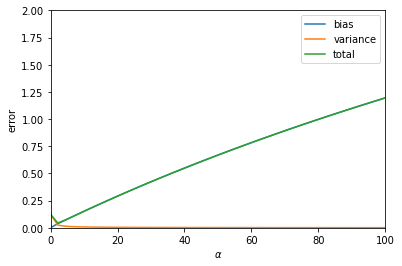

In [42]:
na = 50
alpha = np.linspace(.1,100,na)
error_b = np.zeros(na)
error_v = np.zeros(na)
error_t = np.zeros(na)

for i in range(na):
  error_b[i] = bias(alpha[i])
  error_v[i] = variance(alpha[i])
  error_t[i] = total(alpha[i])

alpha_opt = alpha[np.argmin(error_t)]

print('optimal alpha = ', alpha_opt)
plt.plot(alpha,error_b,label='bias')
plt.plot(alpha,error_v,label='variance')
plt.plot(alpha,error_t,label='total')

plt.xlim([0,100])
plt.ylim([0,2])
plt.xlabel(r'$\alpha$')
plt.ylabel('error')
plt.legend()

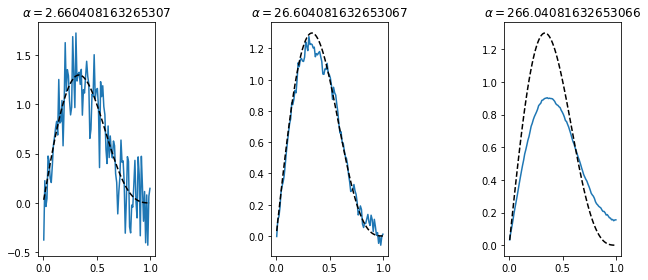

In [30]:
#
alphas = [1e-1*alpha_opt, alpha_opt, 1e1*alpha_opt]
nas = len(alphas)
fig, ax = plt.subplots(1,nas)
for i in range(nas):
  ax[i].plot(x,u_noise(alphas[i]))
  ax[i].plot(x,u,'k--')
  ax[i].set_title(r'$\alpha=$'+str(alphas[i]))

fig.tight_layout()
fig.set_figwidth(10)